In [43]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pygem_eb.processing.plotting_fxns import *
from objectives import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
aa = [0.4,0.5]
kk = [2,3]
winter_result = np.ones((3,len(aa),len(kk)))
summer_result = np.ones((3,len(aa),len(kk)))
for bin in range(3):
    site = ['AB','B','D'][bin]
    labels = []
    for ai,a in enumerate(aa):
        for ki,k in enumerate(kk):
            fn = f'a_{a}_k_{k}_0_bin{bin}.nc'
            ds,startdate,enddate = getds('/home/claire/research/Output/EB/AWS/'+fn)
            winter,summer = seasonal_mass_balance(fp,ds,0,site)
            winter_result[bin,ai,ki] = winter
            summer_result[bin,ai,ki] = summer
            labels.append(f'a={a}, k={k}')
    best_winter = labels[np.argmin(winter_result[bin,:,:])]
    best_summer = labels[np.argmin(summer_result[bin,:,:])]
    print(f'Best winter run for site {site} was {best_winter}, RMSE {np.min(winter_result[bin,:,:])}')
    print(f'Best summer run for site {site} was {best_summer}, RMSE {np.min(summer_result[bin,:,:])}')

Best winter run for site AB was a=0.5, k=3, RMSE 0.14144104184174464
Best summer run for site AB was a=0.4, k=2, RMSE 0.6315050687665379
Best winter run for site B was a=0.5, k=3, RMSE 0.22825189988070485
Best summer run for site B was a=0.5, k=3, RMSE 0.6430983624743158
Best winter run for site D was a=0.5, k=3, RMSE 0.2625039608129057
Best summer run for site D was a=0.5, k=3, RMSE 1.124485028959123


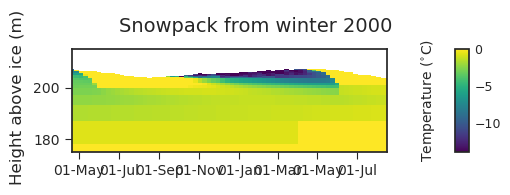

In [28]:
for year in range(2000,2001):
    visualize_layers(ds,0,pd.date_range(f'{year}-04-20 00:00',f'{year+1}-08-20 00:00',freq='7d'),['layertemp'],t='Snowpack from winter '+str(year),plot_ice=True,ylim=(175,215))

In [41]:
def plot_by(ds,bin,time,vars,t='Monthly EB Outputs',by='month'):
    h = 1.5
    fig,axes = plt.subplots(len(vars),1,figsize=(7,h*len(vars)),sharex=True,layout='constrained')
    if len(vars) == 1:
        axes = [axes]
    
    if by == 'month':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).month)
        time_list = np.arange(1,13)
    elif by == 'hour':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).hour)
        time_list = np.arange(0,24)
    elif by == 'doy':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).day_of_year)
        time_list = np.arange(1,366)

    if len(time) == 2:
        start = pd.to_datetime(time[0])
        end = pd.to_datetime(time[1])
        time = pd.date_range(start,end,freq='h')
    ds = ds.sel(time=time,bin=bin)
    c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
    for i,v in enumerate(vars):
        axis = axes[i]
        vararray = np.array(v)
        for var in vararray:
            try:
                c = next(c_iter)
            except:
                c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
                c = next(c_iter)
        
            var_out = []
            for time in time_list:
                ds_sel = ds.where(ds[by] == time,drop=True)
                if 'layer' in var:
                    vardata = ds_sel.isel(layer=0)[var].to_numpy()
                else:
                    vardata = ds_sel[var].to_numpy()
                mean = np.mean(vardata)
                var_out.append(mean)
            axis.plot(time_list,var_out,label=var,color=c)
            axis.legend()
            if by == 'doy':
                axis.axvline(111,color='green')
                axis.axvline(294,color='red')
    if by == 'month':
        months = pd.date_range('2024-01-01','2024-12-31',freq='MS')
        month_names = [date.month_name()[:3] for date in months]
        axis.set_xticks(np.arange(1,13),month_names)
    if by == 'doy':
        axis.set_xlabel('Day of year')
    axis.set_ylabel('Melt (mm w.e.)')
    axis.tick_params(length=5)
    fig.suptitle(t)

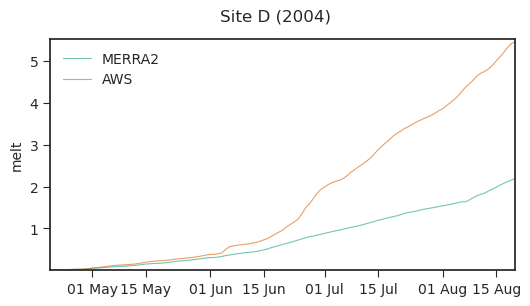

In [72]:
bin = 2
dslist = []
labels = []
ds_not,startdate,enddate = getds(f'~/research/Output/EB/a_0.1_k_0.5_0_bin{bin}.nc')
ds_AWS,startdate,enddate = getds(f'~/research/Output/EB/a_0.1_k_0.5_AWS_0_bin{bin}.nc')
dslist = [ds_not,ds_AWS]
labels = ['MERRA2','AWS']
compare_runs(dslist,0,['2004-04-20','2004-08-20'],['MERRA2','AWS'],'melt',t='Site D (2004)')

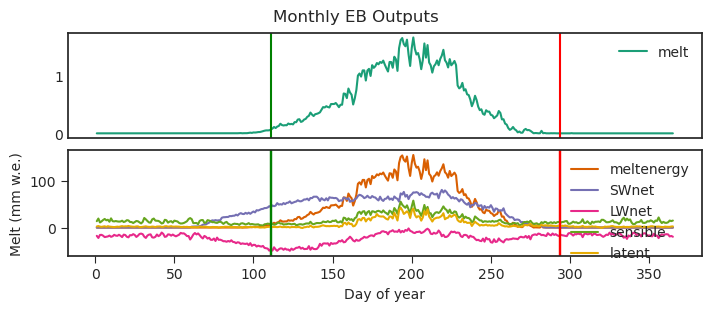

In [47]:

ds.melt.values *= 1000
plot_by(ds,0,[startdate,enddate],[['melt'],['meltenergy','SWnet','LWnet','sensible','latent']],by='doy')

a_0.1_k_2_0_bin2.nc is missing
Best summer run: a_0.3_k_2
Best winter run: a_0.3_k_2


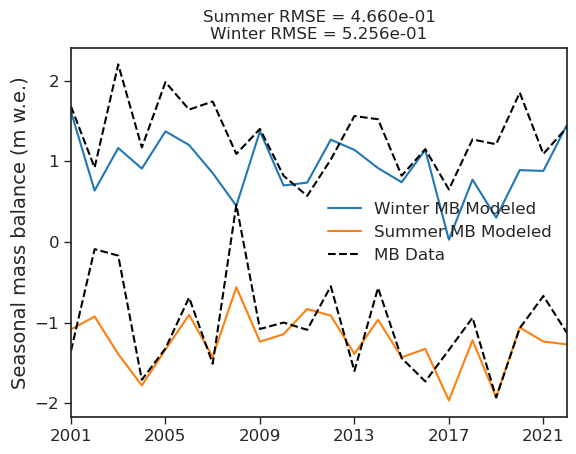

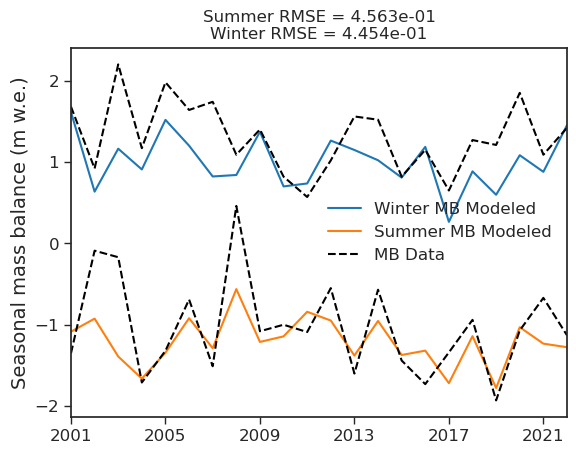

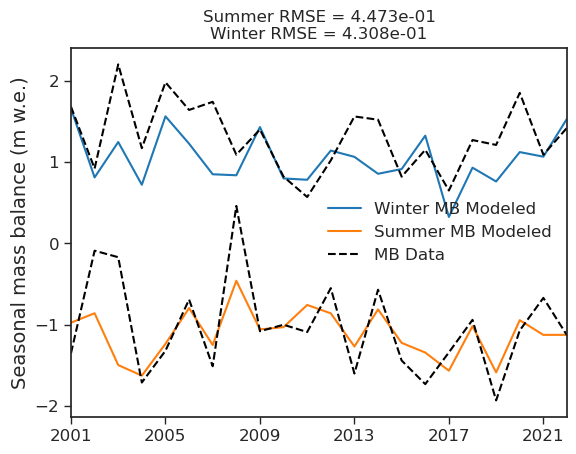

In [49]:
bin = 2
site = ['AB','B','D'][bin]
params = {'a':[0.1,0.3],
        'k':[0.5,2]}
fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
result = {'label':[],'summer':[],'winter':[]}
for a in params['a']:
    for k in params['k']:
        fn = f'a_{a}_k_{k}_0_bin{bin}.nc'
        try:
            ds = xr.open_dataset('~/research/Output/EB/'+fn)
            werr,serr = seasonal_mass_balance(fp,ds,0,site,plot=True)
            result['winter'].append(werr)
            result['summer'].append(serr)
            result['label'].append(fn)
        except:
            print(fn,'is missing')
print('Best summer run:',result['label'][np.argmin(result['summer'])][:-10])
print('Best winter run:',result['label'][np.argmin(result['winter'])][:-10])

In [ ]:
ds.melt.values *= 1000
plot_by(ds,0,[startdate,enddate],[['melt']],by='doy')

Best summer run: a_0.3_k_2
Best winter run: a_0.1_k_0.5


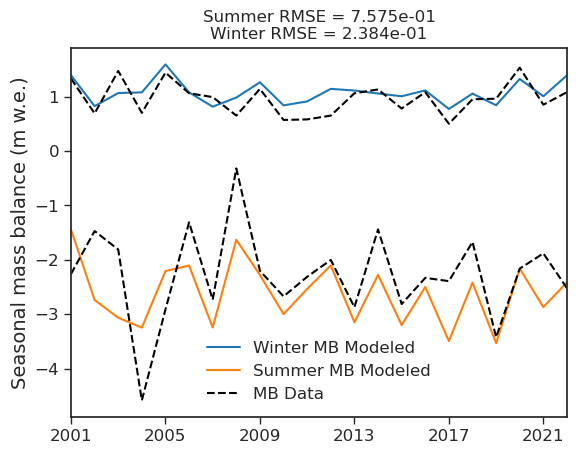

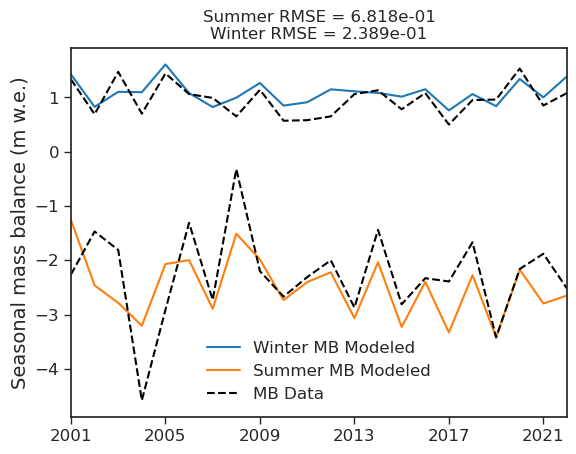

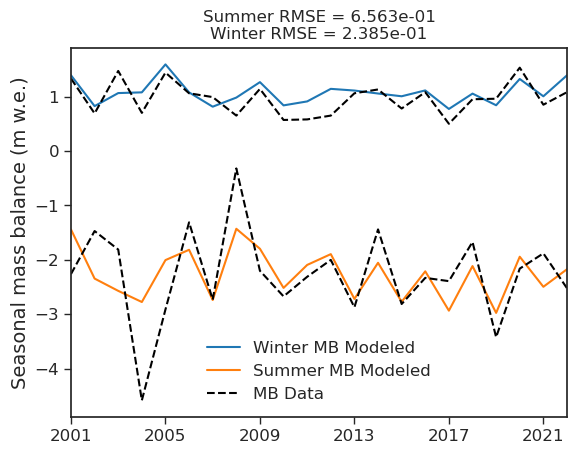

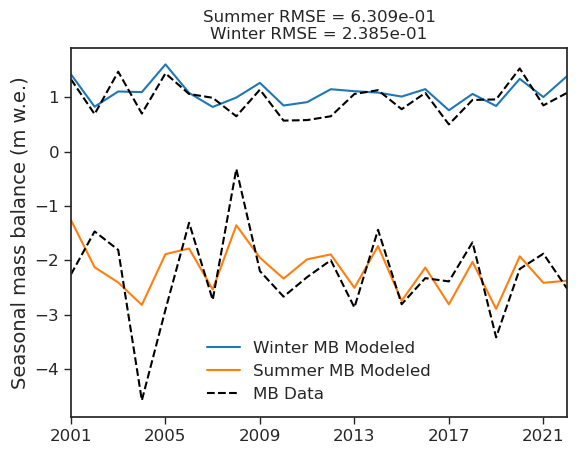

In [12]:
plot_bin(1)